# Machine Learning
## Classification Problem

**Unexpected challenge emerged when it came to splitting the data to train+test and evaluation sets**

![Hysteresis](https://github.com/asyaparfenova/air_condidioner_effectiveness_cost_carbon_footprint/blob/main/images/hysteresis.png?raw=true)

The initial idea was to train the model on the temperature data for the time periods, when the air conditioner was “off” and then to re-construct the “uncooled” temperature, when it was on. But here comes the hysteresis problem: it takes time to cool down the room and, more importantly, the room stays cooler for some time after switching off the cooling and that
time can not be used for training.

![Cutting Tail](https://github.com/asyaparfenova/air_condidioner_effectiveness_cost_carbon_footprint/blob/main/images/classification.png?raw=truee)

To estimate hysteresis lag regression machine learning was used, as the time after changing the state the air conditioner, when our model can not properly predict the right state or, inother worlds, to recognize that the state was changed.

In [47]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import statsmodels.discrete.discrete_model as sm

We will be working with july subset for speed and simplicity

In [29]:
df = pd.read_csv('data/july.csv', index_col='Unnamed: 0')

**Let's start with the splitting**

In [30]:
df.columns

Index(['sensor.ac_power', 'sensor.atmospheric_pressure',
       'sensor.bathroom_humidity', 'sensor.bathroom_temperature',
       'sensor.equipment_temperature', 'sensor.kitchen_humidity',
       'sensor.kitchen_temperature', 'sensor.office_co2',
       'sensor.room_humidity', 'sensor.room_temperature',
       'sensor.weather_humidity', 'sensor.weather_temperature',
       'binary_sensor.balcony_door', 'binary_sensor.kitchen_window',
       'binary_sensor.room_window', 'climate.air_conditioner',
       'climate.air_conditioner_old', 'cover.balcony', 'cover.windows',
       'person.one', 'person.two'],
      dtype='object')

In [31]:
df.isnull().sum()

sensor.ac_power                     0
sensor.atmospheric_pressure         0
sensor.bathroom_humidity            0
sensor.bathroom_temperature         0
sensor.equipment_temperature        0
sensor.kitchen_humidity             0
sensor.kitchen_temperature          0
sensor.office_co2                1192
sensor.room_humidity                0
sensor.room_temperature             0
sensor.weather_humidity             0
sensor.weather_temperature          0
binary_sensor.balcony_door          0
binary_sensor.kitchen_window        0
binary_sensor.room_window           0
climate.air_conditioner             0
climate.air_conditioner_old     44640
cover.balcony                       0
cover.windows                       0
person.one                          0
person.two                          0
dtype: int64

- We can drop *'climate.air_conditioner_old'* and *'sensor.office_co2'* columns, because CO2 level is not important for our modelling and old air conditioner dataset is empty for July.
- Also 'sensor.ac_power' is not important for our nearest goals.

In [32]:
df.drop(['sensor.office_co2'], axis=1, inplace=True)
df.drop(['climate.air_conditioner_old'], axis=1, inplace=True)
df.drop(['sensor.ac_power'], axis=1, inplace=True)

In [33]:
df.shape

(44640, 18)

Let's also redefine our air conditioner state into binary values

In [34]:
df['climate.air_conditioner'].unique()
df['climate.air_conditioner'].replace({'cool':1, 'dry':0, 'fan_only':0, 'off':0}, inplace=True)

And create a feature for time

In [35]:
df['time_hour'] = pd.to_datetime(df.index).hour

**Let's define our X and y**

In [36]:
X = df.drop('climate.air_conditioner', axis=1)

In [37]:
y = df['climate.air_conditioner']

In [38]:
X.shape, y.shape

((44640, 18), (44640,))

**Train/Test split**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train.shape, y_train.shape

((35712, 18), (35712,))

**X_train:** Feature Engineering

In [41]:
X_train.head(3)

,sensor.atmospheric_pressure,sensor.bathroom_humidity,sensor.bathroom_temperature,sensor.equipment_temperature,sensor.kitchen_humidity,sensor.kitchen_temperature,sensor.room_humidity,sensor.room_temperature,sensor.weather_humidity,sensor.weather_temperature,binary_sensor.balcony_door,binary_sensor.kitchen_window,binary_sensor.room_window,cover.balcony,cover.windows,person.one,person.two,time_hour
2020-07-31 19:31:00,1014.0,43.0,23.7,28.1,50.3,24.2,38.6,22.1,36.0,22.9,on,off,off,open,open,not_home,not_home,19
2020-07-29 18:56:00,1014.0,44.0,23.8,28.5,44.7,23.2,43.7,22.9,38.0,20.2,on,off,off,open,open,home,not_home,18
2020-07-30 08:10:00,1018.0,46.0,23.8,28.9,44.7,22.9,39.9,23.0,67.0,18.7,on,off,off,open,open,not_home,not_home,8


Let's define a function for creating a "outside and inside temperature difference" feature and normalize it to the range 0.0 - 1.0

In [42]:
def temp_diff(data):
    new_data = data['sensor.room_temperature'] - data['sensor.weather_temperature']
    return pd.DataFrame(new_data)

temp_diff_scaled = make_pipeline(
    FunctionTransformer(temp_diff),
    MinMaxScaler(),
    )

Let's define a function for creating a "outside and inside humidity difference" feature and normalize it to the range 0.0 - 1.0

In [43]:
def hum_diff(data):
    new_data = data['sensor.room_humidity'] - data['sensor.weather_humidity']
    return pd.DataFrame(new_data)

hum_diff_scaled = make_pipeline(
    FunctionTransformer(hum_diff),
    MinMaxScaler(),
    )

Let's make pipelines for creating "binned time" and "polynomial time" features and normalize them to the range 0.0 - 1.0

In [46]:
bin_then_encode = make_pipeline(
    KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='uniform'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

poly_then_scale = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    MinMaxScaler()
)

In [49]:
fe = ColumnTransformer([('label_encoder', OneHotEncoder(drop='if_binary'), ['binary_sensor.balcony_door',
                                                                            'binary_sensor.room_window',
                                                                            'cover.balcony',
                                                                            'cover.windows',
                                                                            'person.one',
                                                                            'person.two']),
                        ('scaler', MinMaxScaler(), ['sensor.atmospheric_pressure',
                                                    'sensor.room_humidity',
                                                    'sensor.room_temperature',
                                                    'sensor.weather_humidity',
                                                    'sensor.weather_temperature']),
                        ('temp_diff_scaled', temp_diff_scaled, ['sensor.room_temperature',
                                                                'sensor.weather_temperature']),
                        ('hum_diff_scaled', hum_diff_scaled, ['sensor.room_humidity',
                                                              'sensor.weather_humidity']),
                        ('polynomial_time', poly_then_scale, ['time_hour']),
                        ('binned_time', bin_then_encode, ['time_hour']),
])

We intentionaly made some collinear and excessive features - will pick up the right working combination later.

In [50]:
fe.fit(X_train)
X_train_trans = fe.transform(X_train)

In [51]:
X_train_trans[:5]

array([[1.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 0.57142857, 0.00911854, 0.42647059, 0.03030303,
        0.625     , 0.28804348, 0.6200495 , 0.82608696, 0.68241966,
        0.56373798, 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        ],
       [1.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 0.57142857, 0.16413374, 0.54411765, 0.06060606,
        0.484375  , 0.47826087, 0.65841584, 0.7826087 , 0.61247637,
        0.47932933, 1.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        ],
       [1.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 0.76190476, 0.04863222, 0.55882353, 0.5       ,
        0.40625   , 0.56521739, 0.25247525, 0.34782609, 0.12098299,
        0.04208104, 1.        , 0.        , 0.        , 1.        ,
      

### Modelling!

**Baseline Model**

As the baseline model we would choose the "always off" prediction (since AC was much more often off).

Let's check what would be it's accuracy:

In [52]:
baseline_accuracy = 1 - y_train.sum() / y_train.count()
baseline_accuracy

0.7225582437275986

# PROCEED EDITING FROM HERE

#### LogReg

In [27]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_trans, y_train)

LogisticRegression(max_iter=1000)

In [28]:
model_lr.score(X_train_trans, y_train)

0.9036458333333334

#### LogReg/Cross-Validation

In [23]:
accuracy = cross_val_score(model_lr, X_train_trans, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.90774185 0.90032199 0.90660879 0.89988799 0.90716886]


#### LogReg from Statsmodels

In [34]:
logit = sm.Logit(y_train, X_train_trans)
f = logit.fit()
print(f.params)
print(f.summary())

Optimization terminated successfully.
         Current function value: 0.234141
         Iterations 9
x1     5.813031
x2     0.351322
x3     1.005942
x4     0.001750
x5   -14.333595
x6    -1.188940
dtype: float64
                              Logit Regression Results                             
Dep. Variable:     climate.air_conditioner   No. Observations:                35712
Model:                               Logit   Df Residuals:                    35706
Method:                                MLE   Df Model:                            5
Date:                     Tue, 15 Dec 2020   Pseudo R-squ.:                  0.6038
Time:                             20:55:56   Log-Likelihood:                -8361.7
converged:                            True   LL-Null:                       -21103.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

According to statsmodel.Logit the appearance of second person is absolutely irrelevant (it complies with what we noticed before). Let'sexclude it from our further models.

Also, let's actually check other features we excluded before!

In [29]:
X_train.columns

Index(['sensor.atmospheric_pressure', 'sensor.bathroom_humidity',
       'sensor.bathroom_temperature', 'sensor.equipment_temperature',
       'sensor.kitchen_humidity', 'sensor.kitchen_temperature',
       'sensor.office_co2', 'sensor.room_humidity', 'sensor.room_temperature',
       'sensor.weather_humidity', 'sensor.weather_temperature',
       'binary_sensor.balcony_door', 'binary_sensor.kitchen_window',
       'binary_sensor.room_window', 'cover.balcony', 'cover.windows',
       'person.one', 'person.two'],
      dtype='object')

In [30]:
fe_experimental = ColumnTransformer([
    ('label_encoder', OneHotEncoder(drop='if_binary'), ['binary_sensor.balcony_door',
                                                        'binary_sensor.kitchen_window',
                                                        #'binary_sensor.room_window',
                                                        #'cover.balcony',
                                                        'cover.windows',
                                                        'person.one']),
                                                        #'person.two']),
    ('scaler', MinMaxScaler(), [#'sensor.atmospheric_pressure',
                                #'sensor.bathroom_temperature',
                                #'sensor.equipment_temperature',
                                #'sensor.kitchen_humidity',
                                #'sensor.kitchen_temperature',
                                #'sensor.room_humidity',
                                'sensor.room_temperature',
                                'sensor.weather_humidity',
                                'sensor.weather_temperature']),
    ('temp_diff_scaled', temp_diff_scaled, ['sensor.room_temperature', 'sensor.weather_temperature']),
    ('hum_diff_scaled', hum_diff_scaled, ['sensor.room_humidity', 'sensor.weather_humidity']),    
])

In [31]:
fe_experimental.fit(X_train)
X_train_experimental = fe_experimental.transform(X_train)

In [32]:
X_train_experimental[:3]

array([[1.        , 0.        , 1.        , 1.        , 0.42647059,
        0.03030303, 0.625     , 0.28804348, 0.6200495 ],
       [1.        , 0.        , 1.        , 0.        , 0.54411765,
        0.06060606, 0.484375  , 0.47826087, 0.65841584],
       [1.        , 0.        , 1.        , 1.        , 0.55882353,
        0.5       , 0.40625   , 0.56521739, 0.25247525]])

In [33]:
logit_experimental = sm.Logit(y_train, X_train_experimental)
f_exp = logit_experimental.fit()
print(f_exp.params)
print(f_exp.summary())

Optimization terminated successfully.
         Current function value: 0.188624
         Iterations 11
x1    7.195148
x2   -3.473214
x3    0.275201
x4    0.579393
x5   -7.684101
x6   -4.182794
x7    7.355507
x8   -6.835355
x9   -5.553464
dtype: float64
                              Logit Regression Results                             
Dep. Variable:     climate.air_conditioner   No. Observations:                35712
Model:                               Logit   Df Residuals:                    35703
Method:                                MLE   Df Model:                            8
Date:                     Mon, 11 Jan 2021   Pseudo R-squ.:                  0.6808
Time:                             22:50:21   Log-Likelihood:                -6736.1
converged:                            True   LL-Null:                       -21103.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.9

The meaning of features:
- x1: 'binary_sensor.balcony_door',
- x2: 'binary_sensor.kitchen_window',
- x3: 'binary_sensor.room_window',
- x4: 'cover.balcony',
- x5: 'cover.windows',
- x6: 'person.one',
- x7: 'person.two',
- x8: 'sensor.atmospheric_pressure'
- x9: 'sensor.bathroom_humidity',
- x10: 'sensor.bathroom_temperature',
- x11: 'sensor.equipment_temperature',
- x12: 'sensor.kitchen_humidity',
- x13: 'sensor.kitchen_temperature',
- x14: 'sensor.room_humidity',
- x15: 'sensor.room_temperature',
- x16: 'sensor.weather_humidity',
- x17: 'sensor.weather_temperature',
- x18: 'temp_diff_scaled',
- x19: 'hum_diff_scaled'

#### Let's try scikit-logreg again

In [104]:
model_lr = LogisticRegression(max_iter=1000) #, class_weight='balanced')
model_lr.fit(X_train_experimental, y_train)
round(model_lr.score(X_train_experimental, y_train), 3)

0.91

In [35]:
#Cross-Validation?
accuracy = cross_val_score(model_lr, X_train_experimental, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.91558169 0.9052219  0.91150938 0.90380846 0.91192943]


#### Let's check how we can extract probabilities

In [105]:
probs = model_lr.predict_proba(X_train_experimental)

In [88]:
len(y_train), len(probs)

(35712, 35712)

In [89]:
probs[0][0]

0.010662189661812538

Ok, ok. Not only results are slightly better, that's all also make sence. So let's use "experimental" transformation for other models.

#### Decision Tree

In [114]:
model_ds = DecisionTreeClassifier(max_depth=8) #depth should be increased with amount of features increased
model_ds.fit(X_train_experimental, y_train)
round(model_ds.score(X_train_experimental, y_train), 3)

0.967

In [115]:
accuracy = cross_val_score(model_ds, X_train_experimental, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.96598068 0.96472071 0.96513582 0.95701484 0.96261551]


#### Random Forest

In [128]:
model_rf = RandomForestClassifier(max_depth=15, n_estimators=50, random_state=42)
model_rf.fit(X_train_experimental, y_train)
round(model_rf.score(X_train_experimental, y_train), 3)

0.995

In [129]:
accuracy = cross_val_score(model_rf, X_train_experimental, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.99272015 0.99160017 0.99313918 0.99187903 0.99355923]


#### SVC - support vector classificator

In [131]:
model_svc = SVC()
model_svc.fit(X_train_experimental, y_train)
round(model_svc.score(X_train_experimental, y_train), 3)

0.951

In [132]:
accuracy = cross_val_score(model_svc, X_train_experimental, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.95086098 0.94876102 0.95309437 0.94679362 0.95057407]


#### Gradient Boosting Classifier

In [155]:
model_gb = GradientBoostingClassifier(max_depth=4, learning_rate=0.6)
model_gb.fit(X_train_experimental, y_train)
round(model_gb.score(X_train_experimental, y_train), 3)

0.994

In [156]:
accuracy = cross_val_score(model_gb, X_train_experimental, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", accuracy)

Cross-validation scores: [0.99174017 0.99048019 0.99075889 0.99103892 0.99271913]


As expected, RandomForest shown the best results (GradientBoosting is also promising, but need more hyperparameters optimisations).

Let's say we chosen RandomForest

### Testing!!!

In [136]:
#transforming y_test
y_test_trans = y_test.replace({'cool':1, 'dry':0, 'fan_only':0, 'off':0}, inplace=True)

In [137]:
#transforming X_test
X_test_trans = fe_experimental.transform(X_test)

In [138]:
round(model_rf.score(X_test_trans, y_test), 3)

0.993

# WHAT'S NEXT?

- build a column with the data about how long ago AC was turned on/off
- look on dependancy of prediction probability (LogReg) on this delay
- use this information on Regression problem
- split the data for Regression model
- build and train Regression model

# <font color='orange'>Let's catch the tail</font>

In [37]:
df.head()

,sensor.ac_power,sensor.atmospheric_pressure,sensor.bathroom_humidity,sensor.bathroom_temperature,sensor.equipment_temperature,sensor.kitchen_humidity,sensor.kitchen_temperature,sensor.office_co2,sensor.room_humidity,sensor.room_temperature,sensor.weather_humidity,sensor.weather_temperature,binary_sensor.balcony_door,binary_sensor.kitchen_window,binary_sensor.room_window,climate.air_conditioner,cover.balcony,cover.windows,person.one,person.two
2020-07-01 00:00:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,52.0,18.7,on,off,off,off,open,open,not_home,not_home
2020-07-01 00:01:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,52.0,18.7,on,off,off,off,open,open,not_home,not_home
2020-07-01 00:02:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,52.0,18.7,on,off,off,off,open,open,not_home,not_home
2020-07-01 00:03:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,52.0,18.9,on,off,off,off,open,open,not_home,not_home
2020-07-01 00:04:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,52.0,18.9,on,off,off,off,open,open,not_home,not_home


In [38]:
df['climate.air_conditioner'].unique()

array(['off', 'cool', 'fan_only', 'dry'], dtype=object)

In [39]:
df['ac_on'] = df['climate.air_conditioner'].replace({'cool':1, 'dry':0, 'fan_only':0, 'off':0})

In [40]:
df.head()

,sensor.ac_power,sensor.atmospheric_pressure,sensor.bathroom_humidity,sensor.bathroom_temperature,sensor.equipment_temperature,sensor.kitchen_humidity,sensor.kitchen_temperature,sensor.office_co2,sensor.room_humidity,sensor.room_temperature,...,sensor.weather_temperature,binary_sensor.balcony_door,binary_sensor.kitchen_window,binary_sensor.room_window,climate.air_conditioner,cover.balcony,cover.windows,person.one,person.two,ac_on
2020-07-01 00:00:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,18.7,on,off,off,off,open,open,not_home,not_home,0
2020-07-01 00:01:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,18.7,on,off,off,off,open,open,not_home,not_home,0
2020-07-01 00:02:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,18.7,on,off,off,off,open,open,not_home,not_home,0
2020-07-01 00:03:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,18.9,on,off,off,off,open,open,not_home,not_home,0
2020-07-01 00:04:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,18.9,on,off,off,off,open,open,not_home,not_home,0


In [41]:
len(df['ac_on'])

44640

In [42]:
df['ac_on_time'] = 0

In [43]:
time_on = 0
for row in range(len(df['ac_on'])):
    if df['ac_on'][row] == 0:
        time_on = 0
    else:
        time_on += 1
        df['ac_on_time'][row] = time_on
        

<ipython-input-43-3956d6b6bca5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ac_on_time'][row] = time_on


In [44]:
df[['ac_on', 'ac_on_time']][320:340]

,ac_on,ac_on_time
2020-07-01 05:20:00,0,0
2020-07-01 05:21:00,0,0
2020-07-01 05:22:00,0,0
2020-07-01 05:23:00,0,0
2020-07-01 05:24:00,0,0
2020-07-01 05:25:00,0,0
2020-07-01 05:26:00,0,0
2020-07-01 05:27:00,0,0
2020-07-01 05:28:00,0,0
2020-07-01 05:29:00,0,0


#### Repeat for 'ac_off'

In [45]:
df['ac_off'] = df['climate.air_conditioner'].replace({'cool':0, 'dry':1, 'fan_only':1, 'off':1})
df['ac_off_time'] = 0
time_off = 0
for row in range(len(df['ac_off'])):
    if df['ac_off'][row] == 0:
        time_off = 0
    else:
        time_off += 1
        df['ac_off_time'][row] = time_off

<ipython-input-45-c1596258e8ed>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ac_off_time'][row] = time_off


In [46]:
df[['ac_on', 'ac_on_time', 'ac_off', 'ac_off_time']][320:340]

,ac_on,ac_on_time,ac_off,ac_off_time
2020-07-01 05:20:00,0,0,1,321
2020-07-01 05:21:00,0,0,1,322
2020-07-01 05:22:00,0,0,1,323
2020-07-01 05:23:00,0,0,1,324
2020-07-01 05:24:00,0,0,1,325
2020-07-01 05:25:00,0,0,1,326
2020-07-01 05:26:00,0,0,1,327
2020-07-01 05:27:00,0,0,1,328
2020-07-01 05:28:00,0,0,1,329
2020-07-01 05:29:00,0,0,1,330


In [106]:
fe_experimental.fit(df)
X_total = fe_experimental.transform(df)

In [107]:
probs = model_lr.predict_proba(X_total)

In [108]:
df.shape, probs.shape

((44640, 26), (44640, 2))

In [109]:
probs_on = []
probs_off = []
for row in range(len(probs)):
    probs_on.append(probs[row][1])
    probs_off.append(probs[row][0])
    #df['probs_on'][row].replace(probs[row][0], inplace=True)
    #df['probs_off'][row] = probs[row][1]

In [110]:
df['probs_on'] = probs_on
df['probs_off'] = probs_off

In [111]:
df.head()

,sensor.ac_power,sensor.atmospheric_pressure,sensor.bathroom_humidity,sensor.bathroom_temperature,sensor.equipment_temperature,sensor.kitchen_humidity,sensor.kitchen_temperature,sensor.office_co2,sensor.room_humidity,sensor.room_temperature,...,cover.balcony,cover.windows,person.one,person.two,ac_on,ac_on_time,ac_off,ac_off_time,probs_on,probs_off
2020-07-01 00:00:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,open,open,not_home,not_home,0,0,1,1,0.491696,0.508304
2020-07-01 00:01:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,open,open,not_home,not_home,0,0,1,2,0.491696,0.508304
2020-07-01 00:02:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,open,open,not_home,not_home,0,0,1,3,0.491696,0.508304
2020-07-01 00:03:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,open,open,not_home,not_home,0,0,1,4,0.528091,0.471909
2020-07-01 00:04:00,1.0,1004.0,42.0,24.5,29.7,39.5,23.8,NaN,38.3,22.6,...,open,open,not_home,not_home,0,0,1,5,0.528091,0.471909


In [112]:
probs_on = df.groupby('ac_on_time')['probs_on'].mean()[:240]

In [113]:
probs_on.head()

ac_on_time
0    0.082312
1    0.409684
2    0.426038
3    0.420536
4    0.422022
Name: probs_on, dtype: float64

In [114]:
probs_off = df.groupby('ac_off_time')['probs_off'].mean()[:240]

In [115]:
len(probs_on), len(probs_off)

(240, 240)

In [116]:
probs = pd.DataFrame({'Time': probs_on.index, "On":probs_on, "Off":probs_off})
probs

,Time,On,Off
0,0,0.082312,0.211339
1,1,0.409684,0.403675
2,2,0.426038,0.432142
3,3,0.420536,0.461828
4,4,0.422022,0.460740
...,...,...,...
235,235,0.844975,0.965330
236,236,0.845878,0.964896
237,237,0.846419,0.960558
238,238,0.846419,0.960325


In [117]:
probs = probs.melt('Time', var_name='State', value_name='Probability')
probs

,Time,State,Probability
0,0,On,0.082312
1,1,On,0.409684
2,2,On,0.426038
3,3,On,0.420536
4,4,On,0.422022
...,...,...,...
475,235,Off,0.965330
476,236,Off,0.964896
477,237,Off,0.960558
478,238,Off,0.960325


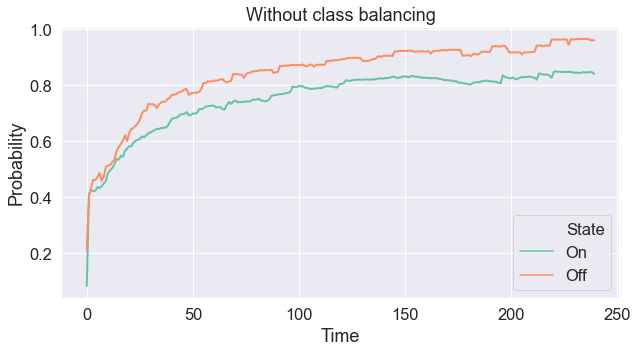

In [118]:
plt.rcParams['figure.figsize'] = (10,5)
sns.lineplot(data=probs, x='Time', y='Probability', hue='State', palette="Set2", linewidth = 2)
plt.title("Without class balancing")
sns.set(font_scale = 1.5)
plt.savefig(os.path.join('./images', 'class_not_balanced_probs.png'))